# Imports

In [44]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

import utils # offload data processing into .py file

In [28]:
data_dir = 'C:/Users/Emily Jensen/OneDrive - UCB-O365/Drone Feedback Data/data/'

Open all of the relevant data files/directories

Emily downloaded the final data and Qualtrics surveys on 4/16/24

Qualtrics export settings:

<img src="qualtrics_export_settings.png" alt="Qualtrics Export Settings" width="500px">

# Load Data

Notes on participants that seem to have restarted the experiment:
- `5bd49bcc25db7b0001794063` restarted after trial 1 - KEEP
- `5c90094e71f3100016181ea9` restarted after trial 3 and again after trial 1 - KEEP
- `5ef9f528c7ae587afa25fe9b` restarted after trial 6 - REMOVE
- `60fcc292d13ae9614d4a77a7` restarted after trial 3 - KEEP
- `6105c41aa4fe602501d5a8cc` restarted after trial 8 - REMOVE
- `610796f1301fccdca446af57` restarted after trial 7 - REMOVE
- `629658baad2881aba974c6c3` restarted after trial 2 - KEEP
- `63026a8fd8429b224cd2a134` restarted before completing trial 1 - KEEP
- `631f1b608af38f654d2a3b1f` restarted after trial 15 - REMOVE
- `637d4196c70a66e28ecede34` restarted before completing trial 1 - KEEP
- `6388b6c86e47b08e1eded1fd` restarted before completing trial 1 - KEEP
- `63ba10de73415d047e1d6731` restarted after trial 5 and again after trial 1 - REMOVE
- `643c6175d46d41e74033994f` restarted after trial 8 and again after trial 1 - REMOVE
- `652ab7948cb59f4c50c7972a` restarted after trial 1 - KEEP
- `6596a5cad60ef105b6c18897` restarted after trial 1 - KEEP
- `65cba99c92b362b45e414da7` restarted after trial 17 - REMOVE

We will keep the participants who complete less than 5 trials before completing a complete run.

Participant `6400dc9f84ed19aeedc1a2cc` seems to have filled out the qualtrics survey twice. The numerical data are the same and the free response questions have very similar content so I feel fine only keeping the first entry.

This has been implemented in `utils.load_data()`

In [2]:
part_file, trial_file, ids = utils.load_data()

Dropped 17 duplicate IDs:
['5bd49bcc25db7b0001794063' '5c90094e71f3100016181ea9'
 '5ef9f528c7ae587afa25fe9b' '60fcc292d13ae9614d4a77a7'
 '6105c41aa4fe602501d5a8cc' '610796f1301fccdca446af57'
 '629658baad2881aba974c6c3' '63026a8fd8429b224cd2a134'
 '631f1b608af38f654d2a3b1f' '637d4196c70a66e28ecede34'
 '6388b6c86e47b08e1eded1fd' '63ba10de73415d047e1d6731'
 '6400dc9f84ed19aeedc1a2cc' '643c6175d46d41e74033994f'
 '652ab7948cb59f4c50c7972a' '6596a5cad60ef105b6c18897'
 '65cba99c92b362b45e414da7']
Final number of IDs in participant file: 140
Final number of IDs in trial file: 140


# Basic stats

This is after filtering out participants that restarted the experiment

In [3]:
utils.run_basic_stats(part_file)

           count  proportion
condition                   
full          46        0.33
score         47        0.34
text          47        0.34
            count  proportion
gender                       
Man            62        0.44
Non-binary      7        0.05
Woman          71        0.51
                  count  proportion
drone_experience                   
None                114        0.81
Some                 20        0.14
Regularly             5        0.04
Professional          1        0.01
                       count  proportion
video_game_experience                   
None                      24        0.17
Monthly                   39        0.28
Weekly                    36        0.26
Daily                     41        0.29
                   count  proportion
feedback_helped                     
Strongly Disagree     22        0.16
Disagree              17        0.12
Neutral               22        0.16
Agree                 59        0.42
Strongly Agree       

# Research Themes

## Perception of Feedback

### What is associated with overall feedback helpfulness rating?

In [4]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings'] + [f'mode_{q}_code' for q in ['motivation', 'manageable', 'actionable', 'timely', 'reflection']]

dep_var = 'feedback_helped'
utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 1.164818
         Iterations: 66
         Function evaluations: 73
         Gradient evaluations: 73
                             OrderedModel Results                             
Dep. Variable:        feedback_helped   Log-Likelihood:                -163.07
Model:                   OrderedModel   AIC:                             364.1
Method:            Maximum Likelihood   BIC:                             420.0
Date:                Thu, 25 Apr 2024                                         
Time:                        12:50:35                                         
No. Observations:                 140                                         
Df Residuals:                     121                                         
Df Model:                          15                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [5]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings'] + [f'mode_{q}_code' for q in ['motivation_collapsed', 'manageable_collapsed', 'actionable_collapsed', 'timely_collapsed', 'reflection_collapsed']]

dep_var = 'feedback_helped_collapsed'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.708879
         Iterations: 70
         Function evaluations: 79
         Gradient evaluations: 79
                                 OrderedModel Results                                
Dep. Variable:     feedback_helped_collapsed   Log-Likelihood:                -99.243
Model:                          OrderedModel   AIC:                             232.5
Method:                   Maximum Likelihood   BIC:                             282.5
Date:                       Thu, 25 Apr 2024                                         
Time:                               12:51:55                                         
No. Observations:                        140                                         
Df Residuals:                            123                                         
Df Model:                                 15                                         
                                     coef    std err  

### What is associated with overall rating for each dimension?

In [6]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_motivation_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 1.382803
         Iterations: 46
         Function evaluations: 51
         Gradient evaluations: 51
                              OrderedModel Results                              
Dep. Variable:     mode_motivation_code   Log-Likelihood:                -193.59
Model:                     OrderedModel   AIC:                             415.2
Method:              Maximum Likelihood   BIC:                             456.4
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:29:36                                         
No. Observations:                   140                                         
Df Residuals:                       126                                         
Df Model:                            10                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----

In [7]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_motivation_collapsed_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.915881
         Iterations: 43
         Function evaluations: 48
         Gradient evaluations: 48
                                   OrderedModel Results                                   
Dep. Variable:     mode_motivation_collapsed_code   Log-Likelihood:                -128.22
Model:                               OrderedModel   AIC:                             280.4
Method:                        Maximum Likelihood   BIC:                             315.7
Date:                            Thu, 25 Apr 2024                                         
Time:                                    14:30:22                                         
No. Observations:                             140                                         
Df Residuals:                                 128                                         
Df Model:                                      10                                         
         

In [8]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_manageable_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 1.169085
         Iterations: 50
         Function evaluations: 56
         Gradient evaluations: 56
                              OrderedModel Results                              
Dep. Variable:     mode_manageable_code   Log-Likelihood:                -163.67
Model:                     OrderedModel   AIC:                             355.3
Method:              Maximum Likelihood   BIC:                             396.5
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:31:10                                         
No. Observations:                   140                                         
Df Residuals:                       126                                         
Df Model:                            10                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----

In [9]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_manageable_collapsed_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.952677
         Iterations: 40
         Function evaluations: 48
         Gradient evaluations: 48
                                   OrderedModel Results                                   
Dep. Variable:     mode_manageable_collapsed_code   Log-Likelihood:                -133.37
Model:                               OrderedModel   AIC:                             290.7
Method:                        Maximum Likelihood   BIC:                             326.0
Date:                            Thu, 25 Apr 2024                                         
Time:                                    14:31:33                                         
No. Observations:                             140                                         
Df Residuals:                                 128                                         
Df Model:                                      10                                         
         

In [10]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_timely_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.957511
         Iterations: 52
         Function evaluations: 59
         Gradient evaluations: 59
                             OrderedModel Results                             
Dep. Variable:       mode_timely_code   Log-Likelihood:                -134.05
Model:                   OrderedModel   AIC:                             296.1
Method:            Maximum Likelihood   BIC:                             337.3
Date:                Thu, 25 Apr 2024                                         
Time:                        14:31:51                                         
No. Observations:                 140                                         
Df Residuals:                     126                                         
Df Model:                          10                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [11]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_timely_collapsed_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.738533
         Iterations: 44
         Function evaluations: 49
         Gradient evaluations: 49
                                 OrderedModel Results                                 
Dep. Variable:     mode_timely_collapsed_code   Log-Likelihood:                -103.39
Model:                           OrderedModel   AIC:                             230.8
Method:                    Maximum Likelihood   BIC:                             266.1
Date:                        Thu, 25 Apr 2024                                         
Time:                                14:32:09                                         
No. Observations:                         140                                         
Df Residuals:                             128                                         
Df Model:                                  10                                         
                                 coef    std 

In [12]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_reflection_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 1.310754
         Iterations: 46
         Function evaluations: 54
         Gradient evaluations: 54
                              OrderedModel Results                              
Dep. Variable:     mode_reflection_code   Log-Likelihood:                -183.51
Model:                     OrderedModel   AIC:                             395.0
Method:              Maximum Likelihood   BIC:                             436.2
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:32:31                                         
No. Observations:                   140                                         
Df Residuals:                       126                                         
Df Model:                            10                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----

In [13]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_reflection_collapsed_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.795676
         Iterations: 46
         Function evaluations: 54
         Gradient evaluations: 54
                                   OrderedModel Results                                   
Dep. Variable:     mode_reflection_collapsed_code   Log-Likelihood:                -111.39
Model:                               OrderedModel   AIC:                             246.8
Method:                        Maximum Likelihood   BIC:                             282.1
Date:                            Thu, 25 Apr 2024                                         
Time:                                    14:32:50                                         
No. Observations:                             140                                         
Df Residuals:                                 128                                         
Df Model:                                      10                                         
         

In [14]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_actionable_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 1.436502
         Iterations: 46
         Function evaluations: 52
         Gradient evaluations: 52
                              OrderedModel Results                              
Dep. Variable:     mode_actionable_code   Log-Likelihood:                -201.11
Model:                     OrderedModel   AIC:                             430.2
Method:              Maximum Likelihood   BIC:                             471.4
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:34:59                                         
No. Observations:                   140                                         
Df Residuals:                       126                                         
Df Model:                            10                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----

In [15]:
ind_vars = ['age', 'drone_experience_code', 
            'video_game_experience_code', 'total_time_seconds', 
            'avg_feedback_time_seconds','avg_trial_time_seconds', 
            'gender_Non-binary', 'gender_Woman', 
            'condition_code', 'n_safe_landings']

dep_var = 'mode_actionable_collapsed_code'

utils.run_ordered_model(dep_var, ind_vars, part_file)

Optimization terminated successfully.
         Current function value: 0.963605
         Iterations: 42
         Function evaluations: 48
         Gradient evaluations: 48
                                   OrderedModel Results                                   
Dep. Variable:     mode_actionable_collapsed_code   Log-Likelihood:                -134.90
Model:                               OrderedModel   AIC:                             293.8
Method:                        Maximum Likelihood   BIC:                             329.1
Date:                            Thu, 25 Apr 2024                                         
Time:                                    14:35:19                                         
No. Observations:                             140                                         
Df Residuals:                                 128                                         
Df Model:                                      10                                         
         

### What is associated with trial rating in each direction?

In [16]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'motivation'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.459320
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:             motivation   Log-Likelihood:                -4086.1
Model:                   OrderedModel   AIC:                             8190.
Method:            Maximum Likelihood   BIC:                             8244.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:35:49                                         
No. Observations:                2800                                         
Df Residuals:                    2791                                         
Df Model:                           5                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [17]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'motivation_collapsed'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 0.971199
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                              OrderedModel Results                              
Dep. Variable:     motivation_collapsed   Log-Likelihood:                -2719.4
Model:                     OrderedModel   AIC:                             5453.
Method:              Maximum Likelihood   BIC:                             5494.
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:36:11                                         
No. Observations:                  2800                                         
Df Residuals:                      2793                                         
Df Model:                             5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------

In [18]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'manageable'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.286556
         Iterations: 22
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:             manageable   Log-Likelihood:                -3602.4
Model:                   OrderedModel   AIC:                             7223.
Method:            Maximum Likelihood   BIC:                             7276.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:36:27                                         
No. Observations:                2800                                         
Df Residuals:                    2791                                         
Df Model:                           5                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [19]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'manageable_collapsed'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 0.994083
         Iterations: 18
         Function evaluations: 22
         Gradient evaluations: 22
                              OrderedModel Results                              
Dep. Variable:     manageable_collapsed   Log-Likelihood:                -2783.4
Model:                     OrderedModel   AIC:                             5581.
Method:              Maximum Likelihood   BIC:                             5622.
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:36:54                                         
No. Observations:                  2800                                         
Df Residuals:                      2793                                         
Df Model:                             5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------

In [20]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'timely'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.056185
         Iterations: 30
         Function evaluations: 34
         Gradient evaluations: 34
                             OrderedModel Results                             
Dep. Variable:                 timely   Log-Likelihood:                -2957.3
Model:                   OrderedModel   AIC:                             5933.
Method:            Maximum Likelihood   BIC:                             5986.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:37:08                                         
No. Observations:                2800                                         
Df Residuals:                    2791                                         
Df Model:                           5                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------

In [21]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'timely_collapsed'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 0.810716
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:       timely_collapsed   Log-Likelihood:                -2270.0
Model:                   OrderedModel   AIC:                             4554.
Method:            Maximum Likelihood   BIC:                             4596.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:37:23                                         
No. Observations:                2800                                         
Df Residuals:                    2793                                         
Df Model:                           5                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [22]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'reflection'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.451882
         Iterations: 26
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:             reflection   Log-Likelihood:                -4065.3
Model:                   OrderedModel   AIC:                             8149.
Method:            Maximum Likelihood   BIC:                             8202.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:38:16                                         
No. Observations:                2800                                         
Df Residuals:                    2791                                         
Df Model:                           5                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [23]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'reflection_collapsed'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 0.930230
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
                              OrderedModel Results                              
Dep. Variable:     reflection_collapsed   Log-Likelihood:                -2604.6
Model:                     OrderedModel   AIC:                             5223.
Method:              Maximum Likelihood   BIC:                             5265.
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:38:32                                         
No. Observations:                  2800                                         
Df Residuals:                      2793                                         
Df Model:                             5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------

In [24]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'actionable'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.498727
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:             actionable   Log-Likelihood:                -4196.4
Model:                   OrderedModel   AIC:                             8411.
Method:            Maximum Likelihood   BIC:                             8464.
Date:                Thu, 25 Apr 2024                                         
Time:                        14:38:45                                         
No. Observations:                2800                                         
Df Residuals:                    2791                                         
Df Model:                           5                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [25]:
ind_vars = ['trial_time_seconds', 'feedback_time_seconds', 'trial', 'outcome_code', 'condition_code']

dep_var = 'actionable_collapsed'

utils.run_ordered_model(dep_var, ind_vars, trial_file)

Optimization terminated successfully.
         Current function value: 1.010890
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
                              OrderedModel Results                              
Dep. Variable:     actionable_collapsed   Log-Likelihood:                -2830.5
Model:                     OrderedModel   AIC:                             5675.
Method:              Maximum Likelihood   BIC:                             5717.
Date:                  Thu, 25 Apr 2024                                         
Time:                          14:39:06                                         
No. Observations:                  2800                                         
Df Residuals:                      2793                                         
Df Model:                             5                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------

### Distributions of dimensional ratings across groups

**MOTIVATION**

In [3]:
utils.run_kruskal('mode_motivation_code', part_file)

mode_motivation_code     0     1     2     3     4
condition                                         
full                  0.04  0.09  0.28  0.41  0.17
score                 0.02  0.13  0.32  0.32  0.21
text                  0.13  0.04  0.17  0.43  0.23
KruskalResult(statistic=0.43155195894923065, pvalue=0.8059158233386281)


In [4]:
utils.run_kruskal('mode_motivation_collapsed_code', part_file)

mode_motivation_collapsed_code     0     1     2
condition                                       
full                            0.17  0.24  0.59
score                           0.15  0.30  0.55
text                            0.17  0.17  0.66
KruskalResult(statistic=0.6481920488654879, pvalue=0.723180796019913)


**MANAGEABLE**

In [5]:
utils.run_kruskal('mode_manageable_code', part_file)

mode_manageable_code     0     1     2     3     4
condition                                         
full                  0.02  0.09  0.63  0.15  0.11
score                 0.06  0.21  0.57  0.06  0.09
text                  0.06  0.04  0.57  0.19  0.13
KruskalResult(statistic=6.632292158000268, pvalue=0.0362924307404955)
         full    score     text
full   1.0000  0.13710  1.00000
score  0.1371  1.00000  0.04875
text   1.0000  0.04875  1.00000


In [6]:
utils.run_kruskal('mode_manageable_collapsed_code', part_file)

mode_manageable_collapsed_code     0     1     2
condition                                       
full                            0.11  0.57  0.33
score                           0.30  0.57  0.13
text                            0.11  0.53  0.36
KruskalResult(statistic=11.809795531702507, pvalue=0.0027260604629594626)
          full     score      text
full   1.00000  0.014940  1.000000
score  0.01494  1.000000  0.005519
text   1.00000  0.005519  1.000000


**ACTIONABLE**

In [7]:
utils.run_kruskal('mode_actionable_code', part_file)

mode_actionable_code     0     1     2     3     4
condition                                         
full                  0.02  0.09  0.24  0.52  0.13
score                 0.15  0.26  0.28  0.17  0.15
text                  0.06  0.09  0.15  0.49  0.21
KruskalResult(statistic=13.057351043388742, pvalue=0.0014609395516731044)
         full     score      text
full   1.0000  0.012600  1.000000
score  0.0126  1.000000  0.002544
text   1.0000  0.002544  1.000000


In [8]:
utils.run_kruskal('mode_actionable_collapsed_code', part_file)

mode_actionable_collapsed_code     0     1     2
condition                                       
full                            0.13  0.22  0.65
score                           0.38  0.28  0.34
text                            0.17  0.15  0.68
KruskalResult(statistic=14.523440697446256, pvalue=0.0007018994844579877)
           full     score      text
full   1.000000  0.003259  1.000000
score  0.003259  1.000000  0.002635
text   1.000000  0.002635  1.000000


**TIMELY**

In [9]:
utils.run_kruskal('mode_timely_code', part_file)

mode_timely_code     0     1     2     3     4
condition                                     
full              0.00  0.00  0.74  0.13  0.13
score             0.02  0.06  0.62  0.19  0.11
text              0.02  0.00  0.60  0.17  0.21
KruskalResult(statistic=2.2477217663637394, pvalue=0.3250224951563972)


In [10]:
utils.run_kruskal('mode_timely_collapsed_code', part_file)

mode_timely_collapsed_code     0     1     2
condition                                   
full                        0.02  0.72  0.26
score                       0.09  0.62  0.30
text                        0.02  0.57  0.40
KruskalResult(statistic=2.6246380095924167, pvalue=0.26919506733620596)


**REFLECTION**

In [11]:
utils.run_kruskal('mode_reflection_code', part_file)

mode_reflection_code     0     1     2     3     4
condition                                         
full                  0.04  0.04  0.22  0.46  0.24
score                 0.09  0.11  0.17  0.38  0.26
text                  0.06  0.06  0.21  0.43  0.23
KruskalResult(statistic=0.27633119068024015, pvalue=0.8709544538045556)


In [12]:
utils.run_kruskal('mode_reflection_collapsed_code', part_file)

mode_reflection_collapsed_code     0     1     2
condition                                       
full                            0.13  0.20  0.67
score                           0.21  0.15  0.64
text                            0.13  0.19  0.68
KruskalResult(statistic=0.5021944141381096, pvalue=0.77794674596029)


### Did they think the feedback helped?

In [13]:
utils.run_kruskal('feedback_helped_code', part_file)

feedback_helped_code     0     1     2     3     4
condition                                         
full                  0.09  0.13  0.22  0.43  0.13
score                 0.21  0.15  0.19  0.30  0.15
text                  0.17  0.09  0.06  0.53  0.15
KruskalResult(statistic=2.602881435028445, pvalue=0.27213943441344146)


In [14]:
utils.run_kruskal('feedback_helped_collapsed_code', part_file)

feedback_helped_collapsed_code     0     1     2
condition                                       
full                            0.22  0.22  0.57
score                           0.36  0.19  0.45
text                            0.26  0.06  0.68
KruskalResult(statistic=4.270066164579718, pvalue=0.11824067863952731)


## Evolution of Performance

For each condition, plot out the success of the trial for each participant

skipping participant 637d4196c70a66e28ecede34 trial 4
skipping participant 6522a86994a5ce0d7bb9feba trial 9


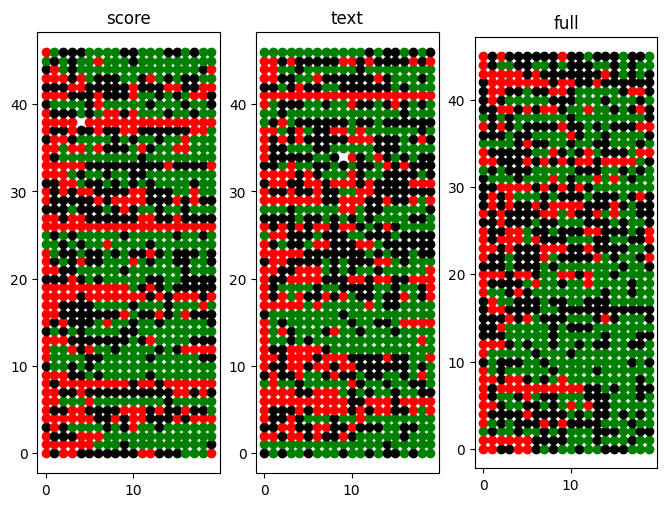

In [73]:
fig, axs = plt.subplots(1,3, figsize=(8,6))
n_trials = 20

conditions = list(ids.keys())

for a in range(len(axs)):
    for i in range(len(ids[conditions[a]])):
        part = ids[conditions[a]].iloc[i]
        data = pd.read_csv(data_dir + part + '/survey_responses.csv')
        for trial in range(n_trials):
            try:
                outcome = data[data['trial'] == trial+1]['outcome'].values[0]
                if outcome == 'Safe':
                    axs[a].plot(trial, i, 'go')
                elif outcome == 'Unsafe':
                    axs[a].plot(trial, i, 'ko')
                else:
                    axs[a].plot(trial, i, 'ro')
            except:
                print(f"skipping participant {part} trial {trial}")

    axs[a].set_aspect('equal')
    axs[a].set_title(f'{conditions[a]}')

plt.show()

### Are there different numbers of successful trials between conditions?

In [20]:
utils.run_kruskal('n_safe_landings', part_file)

n_safe_landings    0     1     2     3     4     5     6     7     8     9   \
condition                                                                     
full             0.02  0.04  0.07  0.09  0.02  0.09  0.07  0.09  0.07  0.02   
score            0.21  0.04  0.04  0.02  0.04  0.02  0.02  0.02  0.04  0.09   
text             0.11  0.06  0.06  0.04  0.04  0.09  0.11  0.04  0.04  0.04   

n_safe_landings    10    11    12    13    14    15    16    17    18    19  
condition                                                                    
full             0.09  0.13  0.04  0.09  0.02  0.00  0.04  0.02  0.00  0.00  
score            0.04  0.04  0.04  0.09  0.06  0.06  0.06  0.04  0.00  0.00  
text             0.04  0.04  0.06  0.06  0.02  0.02  0.04  0.00  0.04  0.02  
KruskalResult(statistic=0.3282885481106896, pvalue=0.8486195792596276)


In [4]:
utils.run_anova('n_safe_landings', part_file)

F_onewayResult(statistic=0.10932977141061748, pvalue=0.8965128827700789)


In [21]:
utils.run_kruskal('n_unsafe_landings', part_file)

n_unsafe_landings    0     1     2     3     4     5     6     7     8     9   \
condition                                                                       
full               0.00  0.00  0.02  0.02  0.11  0.00  0.13  0.09  0.17  0.13   
score              0.04  0.02  0.04  0.13  0.13  0.13  0.02  0.09  0.09  0.04   
text               0.02  0.02  0.11  0.04  0.11  0.06  0.04  0.06  0.13  0.09   

n_unsafe_landings    10    11    12    13    14    15    16  
condition                                                    
full               0.09  0.13  0.04  0.02  0.02  0.00  0.02  
score              0.02  0.09  0.06  0.09  0.02  0.00  0.00  
text               0.04  0.11  0.11  0.04  0.00  0.02  0.00  
KruskalResult(statistic=3.7317756447577453, pvalue=0.15475875059211597)


In [5]:
utils.run_anova('n_unsafe_landings', part_file)

F_onewayResult(statistic=2.0800743417168293, pvalue=0.1288485429731383)


In [22]:
utils.run_kruskal('n_crashes', part_file)

n_crashes    0     1     2     3     4     5     6     7     8     10    11  \
condition                                                                     
full       0.13  0.20  0.09  0.15  0.07  0.07  0.09  0.11  0.04  0.02  0.04   
score      0.06  0.17  0.11  0.15  0.06  0.04  0.06  0.15  0.06  0.00  0.02   
text       0.13  0.06  0.13  0.11  0.06  0.13  0.09  0.11  0.04  0.02  0.04   

n_crashes    12    13    16    17    19    20    21  
condition                                            
full       0.00  0.00  0.00  0.00  0.00  0.00  0.00  
score      0.00  0.02  0.02  0.02  0.02  0.00  0.02  
text       0.02  0.02  0.00  0.02  0.00  0.02  0.00  
KruskalResult(statistic=2.427835812493259, pvalue=0.29703125612261755)


In [6]:
utils.run_anova('n_crashes', part_file)

F_onewayResult(statistic=1.8774914729229217, pvalue=0.1568881070997451)


### Differences in outcomes in first/last half of the experiment?

In [3]:
utils.run_ttest_quantiles('Crash', [0.5, 0.5], part_file, trial_file)

TtestResult(statistic=5.633664455670916, pvalue=4.320430451907026e-08, df=278.0)


In [4]:
utils.run_ttest_quantiles('Unsafe', [0.5, 0.5], part_file, trial_file)

TtestResult(statistic=0.8505916423258506, pvalue=0.3957282418771677, df=278.0)


In [5]:
utils.run_ttest_quantiles('Safe', [0.5, 0.5], part_file, trial_file)

TtestResult(statistic=-5.235443102333366, pvalue=3.25070245666022e-07, df=278.0)


In [6]:
utils.run_ttest_quantiles('Crash', [0.5, 0.5], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=2.4386545123528447, pvalue=0.016661783261118435, df=92.0)


In [7]:
utils.run_ttest_quantiles('Unsafe', [0.5, 0.5], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=1.4493606400646586, pvalue=0.1506371503822467, df=92.0)


In [8]:
utils.run_ttest_quantiles('Safe', [0.5, 0.5], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=-3.062685498520051, pvalue=0.002876730761670611, df=92.0)


In [9]:
utils.run_ttest_quantiles('Crash', [0.5, 0.5], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=3.1905611577968975, pvalue=0.0019425953332966122, df=92.0)


In [10]:
utils.run_ttest_quantiles('Unsafe', [0.5, 0.5], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=-0.8075754942814276, pvalue=0.4214180868540339, df=92.0)


In [11]:
utils.run_ttest_quantiles('Safe', [0.5, 0.5], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=-2.077179514449732, pvalue=0.0405723280140886, df=92.0)


In [12]:
utils.run_ttest_quantiles('Crash', [0.5, 0.5], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=4.720723780858188, pvalue=8.586253857861992e-06, df=90.0)


In [13]:
utils.run_ttest_quantiles('Unsafe', [0.5, 0.5], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=0.893558875097702, pvalue=0.37394117316444864, df=90.0)


In [14]:
utils.run_ttest_quantiles('Safe', [0.5, 0.5], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=-4.152592211179453, pvalue=7.459320283752578e-05, df=90.0)


In [225]:
outcome_counts2['safe_diffs'] = outcome_counts2['Safe'] - outcome_counts1['Safe']
outcome_counts2['unsafe_diffs'] = outcome_counts2['Unsafe'] - outcome_counts1['Unsafe']
outcome_counts2['crash_diffs'] = outcome_counts2['Crash'] - outcome_counts1['Crash']

In [226]:
stats.f_oneway(outcome_counts2[outcome_counts2['condition'] == 'score']['safe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['safe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['safe_diffs'])

F_onewayResult(statistic=1.6430121371757918, pvalue=0.1971841221169359)

In [227]:
stats.kruskal(outcome_counts2[outcome_counts2['condition'] == 'score']['safe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['safe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['safe_diffs'])

KruskalResult(statistic=2.7350356698010168, pvalue=0.254738478422149)

In [228]:
stats.f_oneway(outcome_counts2[outcome_counts2['condition'] == 'score']['unsafe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['unsafe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['unsafe_diffs'])

F_onewayResult(statistic=2.909467117065238, pvalue=0.057880514075348465)

In [229]:
stats.kruskal(outcome_counts2[outcome_counts2['condition'] == 'score']['unsafe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['unsafe_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['unsafe_diffs'])

KruskalResult(statistic=6.819249735520675, pvalue=0.033053597520524024)

In [233]:
sp.posthoc_dunn(outcome_counts2, val_col='unsafe_diffs', group_col='condition', p_adjust='bonferroni')

,full,score,text
full,1.000000,1.00000,0.219093
score,1.000000,1.00000,0.033360
text,0.219093,0.03336,1.000000


In [230]:
stats.f_oneway(outcome_counts2[outcome_counts2['condition'] == 'score']['crash_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['crash_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['crash_diffs'])

F_onewayResult(statistic=0.644283694216729, pvalue=0.5266218067470263)

In [231]:
stats.kruskal(outcome_counts2[outcome_counts2['condition'] == 'score']['crash_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'text']['crash_diffs'],
              outcome_counts2[outcome_counts2['condition'] == 'full']['crash_diffs'])

KruskalResult(statistic=0.8000267500539454, pvalue=0.6703110805469004)

In [232]:
outcome_counts2.groupby('condition')[['crash_diffs','unsafe_diffs','safe_diffs']].mean()

,crash_diffs,unsafe_diffs,safe_diffs
condition,,,
full,-1.826087,-0.347826,2.173913
score,-1.340426,-0.659574,2.000000
text,-1.638298,0.361702,1.319149


### What about first and last quarter?

In [234]:
first_quarter = all_responses[all_responses['trial'] < 6]
last_quarter = all_responses[all_responses['trial'] >= 16]

outcome_counts_q1 = pd.merge(first_quarter.groupby('prolific_id')['outcome'].value_counts().unstack(), merged_filtered[['prolific_id', 'condition']], left_index=True, right_on='prolific_id')
outcome_counts_q4 = pd.merge(last_quarter.groupby('prolific_id')['outcome'].value_counts().unstack(), merged_filtered[['prolific_id', 'condition']], left_index=True, right_on='prolific_id')

In [15]:
utils.run_ttest_quantiles('Crash', [0.25, 0.75], part_file, trial_file)

TtestResult(statistic=8.010999084784098, pvalue=3.147803515352688e-14, df=278.0)


In [16]:
utils.run_ttest_quantiles('Unsafe', [0.25, 0.75], part_file, trial_file)

TtestResult(statistic=1.4169572551332483, pvalue=0.15761508724495682, df=278.0)


In [17]:
utils.run_ttest_quantiles('Safe', [0.25, 0.75], part_file, trial_file)

TtestResult(statistic=-8.427673115158571, pvalue=1.9249792954425605e-15, df=278.0)


In [18]:
utils.run_ttest_quantiles('Crash', [0.25, 0.75], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=3.7037499116624994, pvalue=0.0003621406437764596, df=92.0)


In [19]:
utils.run_ttest_quantiles('Unsafe', [0.25, 0.75], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=1.4371535059124823, pvalue=0.15406675214338203, df=92.0)


In [20]:
utils.run_ttest_quantiles('Safe', [0.25, 0.75], part_file, trial_file, idx=ids['score'])

TtestResult(statistic=-4.735188528307348, pvalue=7.912579661417964e-06, df=92.0)


In [21]:
utils.run_ttest_quantiles('Crash', [0.25, 0.75], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=4.854698921987593, pvalue=4.912735619232404e-06, df=92.0)


In [22]:
utils.run_ttest_quantiles('Unsafe', [0.25, 0.75], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=-0.5601363976428997, pvalue=0.5767478158549038, df=92.0)


In [23]:
utils.run_ttest_quantiles('Safe', [0.25, 0.75], part_file, trial_file, idx=ids['text'])

TtestResult(statistic=-3.7357130085251193, pvalue=0.00032445312046758425, df=92.0)


In [24]:
utils.run_ttest_quantiles('Crash', [0.25, 0.75], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=5.952522654434597, pvalue=5.0037872772396944e-08, df=90.0)


In [25]:
utils.run_ttest_quantiles('Unsafe', [0.25, 0.75], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=1.680399992113654, pvalue=0.09634737767740048, df=90.0)


In [26]:
utils.run_ttest_quantiles('Safe', [0.25, 0.75], part_file, trial_file, idx=ids['full'])

TtestResult(statistic=-6.418463814719516, pvalue=6.306000288633041e-09, df=90.0)


In [247]:
outcome_counts_q4['safe_diffs'] = outcome_counts_q4['Safe'] - outcome_counts_q1['Safe']
outcome_counts_q4['unsafe_diffs'] = outcome_counts_q4['Unsafe'] - outcome_counts_q1['Unsafe']
outcome_counts_q4['crash_diffs'] = outcome_counts_q4['Crash'] - outcome_counts_q1['Crash']

In [248]:
stats.f_oneway(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['safe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['safe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['safe_diffs'])

F_onewayResult(statistic=1.2649347727221183, pvalue=0.2855330994390296)

In [249]:
stats.kruskal(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['safe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['safe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['safe_diffs'])

KruskalResult(statistic=2.4724571350413926, pvalue=0.2904776716248768)

In [250]:
stats.f_oneway(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['unsafe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['unsafe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['unsafe_diffs'])

F_onewayResult(statistic=1.759523461800475, pvalue=0.17599403880751385)

In [251]:
stats.kruskal(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['unsafe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['unsafe_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['unsafe_diffs'])

KruskalResult(statistic=3.8702532961464042, pvalue=0.14440597892638643)

In [252]:
stats.f_oneway(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['crash_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['crash_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['crash_diffs'])

F_onewayResult(statistic=0.26900476844327365, pvalue=0.7645422838139977)

In [253]:
stats.kruskal(outcome_counts_q4[outcome_counts_q4['condition'] == 'score']['crash_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'text']['crash_diffs'],
              outcome_counts_q4[outcome_counts_q4['condition'] == 'full']['crash_diffs'])

KruskalResult(statistic=0.5204944662009738, pvalue=0.7708609798923889)

In [254]:
outcome_counts_q4.groupby('condition')[['crash_diffs','unsafe_diffs','safe_diffs']].mean()

,crash_diffs,unsafe_diffs,safe_diffs
condition,,,
full,-1.391304,-0.413043,1.804348
score,-1.191489,-0.382979,1.595745
text,-1.404255,0.148936,1.255319


### Look at robustness and efficiency

In [29]:
# what are max and min values for the robustness and efficiency measures?
robustness_cols = ['left_boundary',	'right_boundary', 'top_boundary', 'bottom_boundary', 'landing_left', 'landing_right', 'landing_speed','landing_angle']
robustness_files = glob.glob(f'{data_dir}*/*/robustness.csv')
robustness_vals = {v : {'max':-99999, 'min':99999} for v in robustness_cols}

{'left_boundary': {'max': -99999, 'min': 99999},
 'right_boundary': {'max': -99999, 'min': 99999},
 'top_boundary': {'max': -99999, 'min': 99999},
 'bottom_boundary': {'max': -99999, 'min': 99999},
 'landing_left': {'max': -99999, 'min': 99999},
 'landing_right': {'max': -99999, 'min': 99999},
 'landing_speed': {'max': -99999, 'min': 99999},
 'landing_angle': {'max': -99999, 'min': 99999}}

In [38]:
for f in robustness_files:
    df = pd.read_csv(f)
    for col in robustness_cols:
        if df[col].min() < robustness_vals[col]['min']:
            robustness_vals[col]['min'] = min(df[col])
        if df[col].max() > robustness_vals[col]['max']:
            robustness_vals[col]['max'] = max(df[col])

robustness_vals

{'left_boundary': {'max': 1209.864, 'min': 0.357},
 'right_boundary': {'max': 1209.643, 'min': 0.1359999999999672},
 'top_boundary': {'max': 574.995, 'min': 0.004000000000019},
 'bottom_boundary': {'max': 573.996, 'min': -0.9950000000000044},
 'landing_left': {'max': 559.864, 'min': -649.643},
 'landing_right': {'max': 849.643, 'min': -359.86400000000003},
 'landing_speed': {'max': 15.0, 'min': -17.015621187164243},
 'landing_angle': {'max': 5.0, 'min': -23.648}}

skipping participant 637d4196c70a66e28ecede34 trial 4
skipping participant 6522a86994a5ce0d7bb9feba trial 9


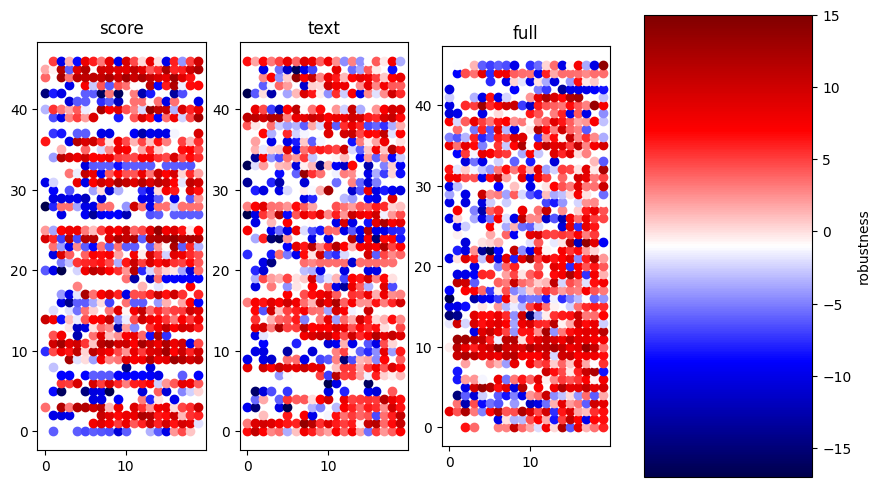

In [71]:
fig, axs = plt.subplots(1,4, figsize=(10,6))
n_trials = 20
var = 'landing_speed'

cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=robustness_vals[var]['min'], vmax=robustness_vals[var]['max'])

conditions = list(ids.keys())

for a in range(len(axs)-1):
    for i in range(len(ids[conditions[a]])):
        part = ids[conditions[a]].iloc[i]
        data = pd.read_csv(data_dir + part + '/survey_responses.csv')
        for trial in range(n_trials):
            try:
                outcome = data[data['trial'] == trial+1]['outcome'].values[0]
                if outcome in ['Safe', 'Unsafe']:
                    trial_data = pd.read_csv(f"{data_dir}{part}/trial_{trial+1}/robustness.csv")
                    val = trial_data.iloc[-1][var]
                    val_normed = (val - robustness_vals[var]['min'])/(robustness_vals[var]['max'] - robustness_vals[var]['min'])
                    c = cmap(val_normed)
                    axs[a].plot(trial, i, marker='o', color=c)
            except:
                print(f"skipping participant {part} trial {trial}")

    axs[a].set_aspect('equal')
    axs[a].set_title(f'{conditions[a]}')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='robustness',cax=axs[-1])
plt.show()

skipping participant 637d4196c70a66e28ecede34 trial 4
skipping participant 6522a86994a5ce0d7bb9feba trial 9


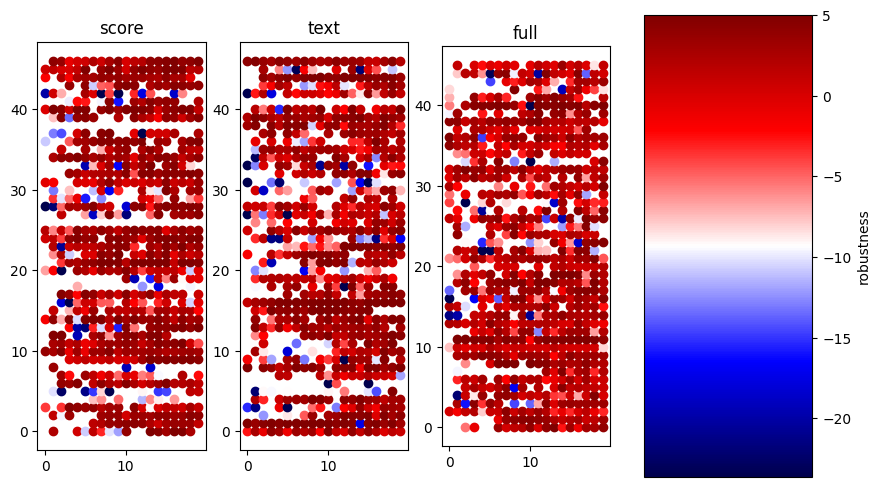

In [72]:
fig, axs = plt.subplots(1,4, figsize=(10,6))
n_trials = 20
var = 'landing_angle'

cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=robustness_vals[var]['min'], vmax=robustness_vals[var]['max'])

conditions = list(ids.keys())

for a in range(len(axs)-1):
    for i in range(len(ids[conditions[a]])):
        part = ids[conditions[a]].iloc[i]
        data = pd.read_csv(data_dir + part + '/survey_responses.csv')
        for trial in range(n_trials):
            try:
                outcome = data[data['trial'] == trial+1]['outcome'].values[0]
                if outcome in ['Safe', 'Unsafe']:
                    trial_data = pd.read_csv(f"{data_dir}{part}/trial_{trial+1}/robustness.csv")
                    val = trial_data.iloc[-1][var]
                    val_normed = (val - robustness_vals[var]['min'])/(robustness_vals[var]['max'] - robustness_vals[var]['min'])
                    c = cmap(val_normed)
                    axs[a].plot(trial, i, marker='o', color=c)
            except:
                print(f"skipping participant {part} trial {trial}")

    axs[a].set_aspect('equal')
    axs[a].set_title(f'{conditions[a]}')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='robustness',cax=axs[-1])
plt.show()

# Pulling out qualitative stuff

Grab all the images. This only needs to be done once.

In [ ]:
utils.copy_images(part_file['prolific_id'])